In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy 
from scipy.signal import resample_poly, butter, lfilter,freqs,filtfilt,sosfilt,sosfiltfilt
from scipy.fft import fft
import pywt


In [4]:
#read in csv file for Apia buoy
apia = pd.read_csv(r'C:\Users\kelsa\Dropbox\456Final\Buoys\apia.csv')
#convert month column '3' to '03' format
apia['MM'] = apia['MM'].apply(lambda x: '{:02d}'.format(x))

#drop values of height = 9999
apia = apia[apia['HEIGHT'] != 9999]


In [5]:
#converting columns into single datetime object
# assigning columns
year = '#YY'  
month = 'MM'  
day = 'DD' 
hour = 'hh'  
minute = 'mm' 
second = 'ss' 

# Adding a new datetime column for year, month, day, hour, minute, and second
apia['Date'] = pd.to_datetime(apia[year].astype(str) + 
                              apia[month].astype(str).str.zfill(2) + 
                              apia[day].astype(str).str.zfill(2) +
                              apia[hour].astype(str).str.zfill(2) +
                              apia[minute].astype(str).str.zfill(2) +
                              apia[second].astype(str).str.zfill(2), 
                              format='%Y%m%d%H%M%S')
    
apia.set_index(apia['Date'], inplace=True)

In [6]:
# Extract sample frequency "T" and "height" columns
T = apia['T']
height = apia['HEIGHT']

#normalize height
height_avg = np.mean(height)
apia['height_norm'] = height - height_avg
print(height_avg)

4978.044915212981


In [7]:
#separate data by sampling frequency
apia1 = apia[apia['T'] == 1].copy()
apia2 = apia[apia['T'] == 2].copy()
apia3 = apia[apia['T'] == 3].copy()

#reset the index for each DataFrame
apia1.reset_index(drop=True, inplace=True)
apia2.reset_index(drop=True, inplace=True)
apia3.reset_index(drop=True, inplace=True)

apia1.set_index(apia1['Date'], inplace=True)
time1 = apia1['Date']
apia1.drop(columns=['Date'], inplace=True)

apia2.set_index(apia2['Date'], inplace=True)
time2 = apia2['Date']
apia2.drop(columns=['Date'], inplace=True)

apia3.set_index(apia3['Date'], inplace=True)
time3 = apia3['Date']
apia3.drop(columns=['Date'], inplace=True)

apia.drop(columns=['Date'], inplace=True)

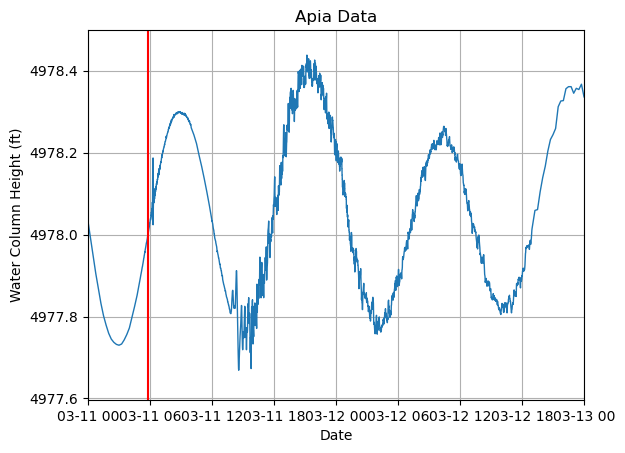

In [8]:
plt.figure()
plt.plot(apia.index, height, lw = 1)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Water Column Height (ft)')
plt.xlim(pd.Timestamp('2011-03-11'), max(apia.index))
plt.title('Apia Data')
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c = 'red')
plt.savefig('ApiaData.png')

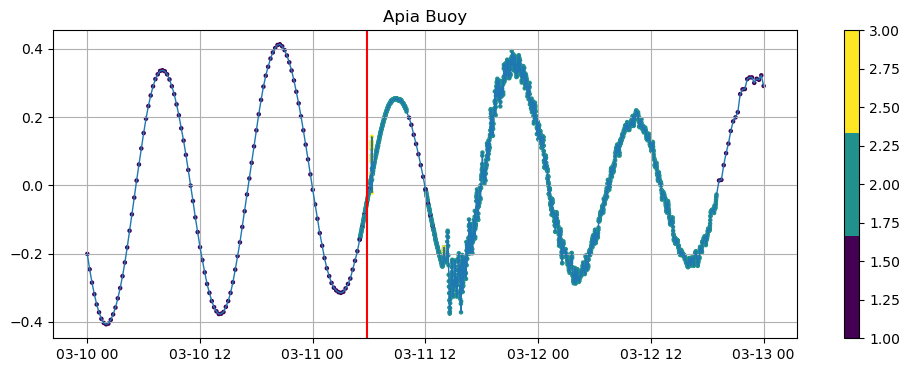

In [9]:
#plot data
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, 3)))
plt.figure(figsize = (12,4))
plt.plot(apia.index, apia['height_norm'], linewidth=1)
plt.scatter(apia.index, apia['height_norm'], c = apia['T'], cmap = cmap, s = 5)
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c = 'red')
plt.colorbar()
plt.grid()
plt.title('Apia Buoy')
plt.savefig('apia_Tcolor.png')
plt.show()



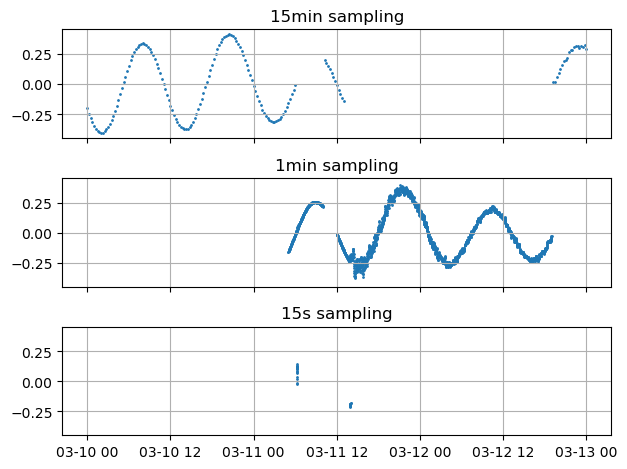

In [10]:
# Create subplots
fig, axs = plt.subplots(3, 1, sharex = True, sharey = True)

# Scatter plot for apia1
axs[0].scatter(apia1.index, apia1['height_norm'], s=1)
axs[0].set_title('15min sampling')
axs[0].grid()

# Scatter plot for apia2
axs[1].scatter(apia2.index, apia2['height_norm'], s=1)
axs[1].set_title('1min sampling')
axs[1].grid()

# Scatter plot for apia3
axs[2].scatter(apia3.index, apia3['height_norm'], s=1)
axs[2].set_title('15s sampling')
axs[2].grid()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [11]:
# Resample the 'HEIGHT' column to 1 minute frequency
resamp = apia['height_norm'].resample('15S').mean()

# Optionally, fill missing values using linear interpolation
resamp = resamp.interpolate(method='linear')

# Create a DataFrame from the resampled Series
resamp_df = pd.DataFrame(resamp)

# Assign column names to the DataFrame
resamp_df.columns = ['height_resampled']

Text(0.5, 1.0, 'Resampled Data to 15s')

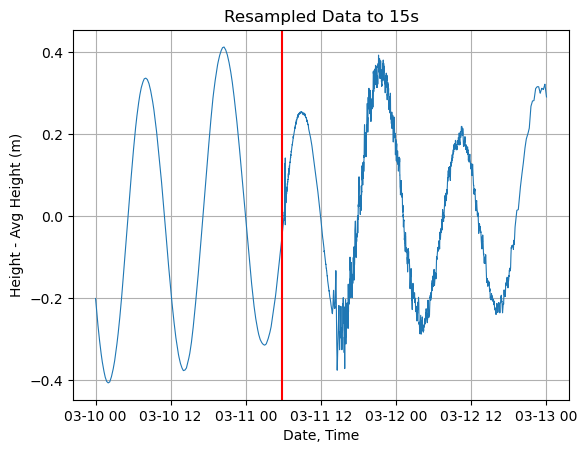

In [12]:
plt.figure()
plt.plot(resamp_df.index, resamp_df['height_resampled'], linewidth = 0.8)
plt.grid()
plt.xlabel('Date, Time')
plt.ylabel('Height - Avg Height (m)')
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c = 'red')
plt.title('Resampled Data to 15s')
            

Text(0, 0.5, 'Amplitude')

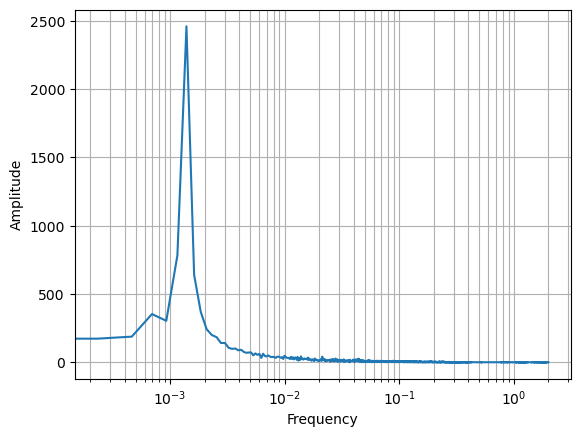

In [13]:
heights = resamp_df['height_resampled']
N = len(resamp_df['height_resampled'])
sample_freq = 4 #4 samples per min
dt = 1 / sample_freq

apia_fft = np.fft.fftshift(np.fft.fft(heights))
freq = np.fft.fftshift(np.fft.fftfreq(N, dt))
amp = np.abs(apia_fft)

plt.figure()
plt.semilogx(freq, amp)
plt.grid(which = 'both')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

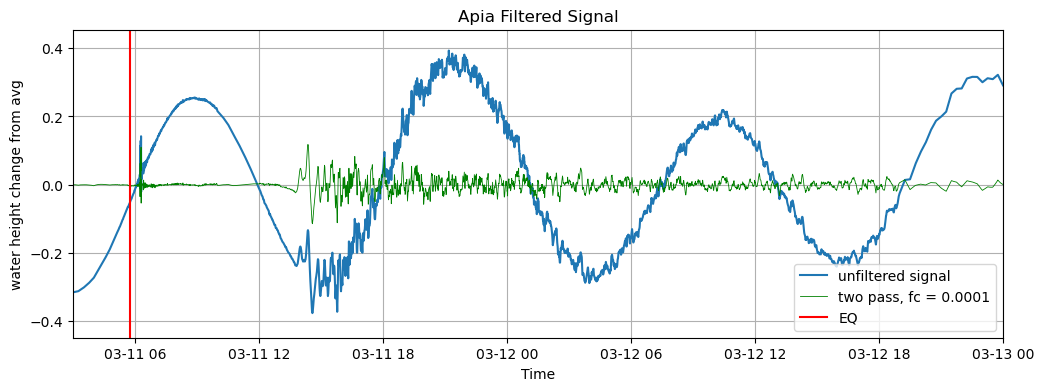

In [14]:
# Define the filter parameters
poles = 4  # Filter order
fc =  0.0001 # Corner frequency in Hz
fs = 1/15 #1 sample every 15 sec 

# Calculate the normalized corner frequency
fnyquist = 0.5 * fs
normalized_corner_freq = fc / fnyquist

# Design the Butterworth highpass filter
b, a = butter(poles, normalized_corner_freq, btype='high', analog=False)

#get the frequency response
w, h = scipy.signal.freqz(b, a, worN=4096)

#convert from angular to linear freq
f = (w) / (np.pi)
f = f*fnyquist

apia_filt = lfilter(b, a, heights)
apia_filt2 = filtfilt(b, a, heights)

plt.figure(figsize = (12,4))
plt.plot(resamp_df.index,heights,label='unfiltered signal')
plt.plot(resamp_df.index, apia_filt2,label=r'two pass, fc = %s' % fc, linewidth = 0.6, c = 'green')
plt.xlim(pd.Timestamp('2011-03-11 03:00:00'), pd.Timestamp('2011-03-13'))
plt.xlabel('Time')
plt.ylabel('water height change from avg')
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c = 'red', label = 'EQ')
plt.title('Apia Filtered Signal')
plt.legend()
plt.grid()
plt.savefig('apia_filt_plot.png')




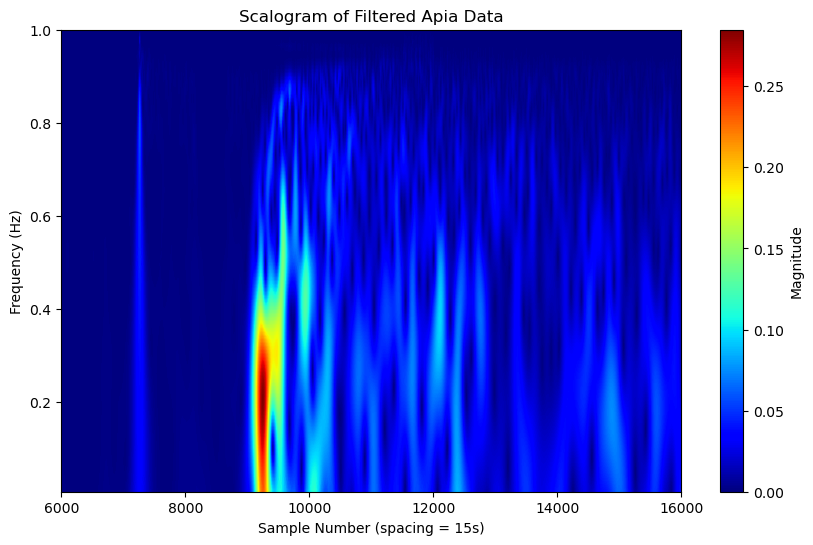

<Figure size 640x480 with 0 Axes>

In [17]:

# Define wavelet parameters
wavelet = 'cmor1.5-1.0'  # parameters for the cmor wavelet
scales = np.arange(1, 128)  # Range of scales for wavelet

# Perform continuous wavelet transform
coefficients, frequencies = pywt.cwt(apia_filt2, scales, wavelet)

# Plot scalogram
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[0, len(apia_filt2), frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.title('Scalogram of Filtered Apia Data')
plt.xlim(6000,16000)
plt.xlabel('Sample Number (spacing = 15s)')
plt.ylabel('Frequency (Hz)')
plt.show()
plt.savefig('apia_scalogram.png')

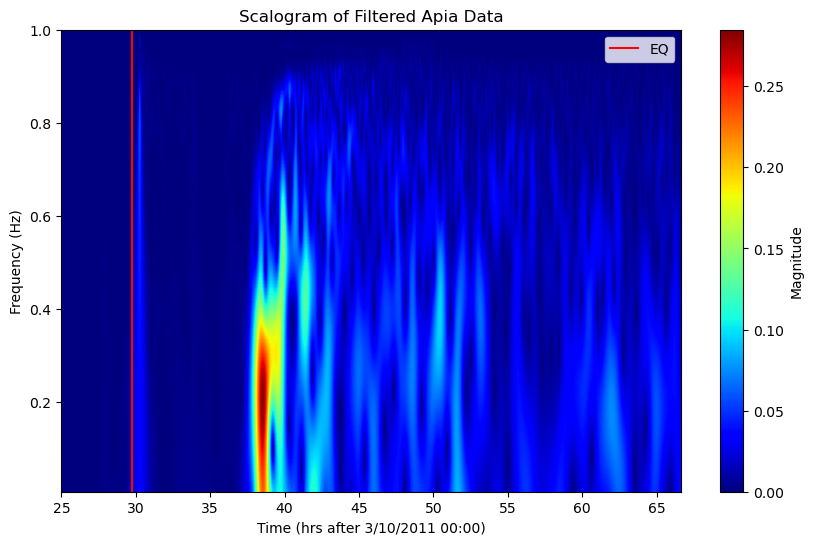

<Figure size 640x480 with 0 Axes>

In [19]:
# Define wavelet parameters
wavelet = 'cmor1.5-1.0'  # parameters for the cmor wavelet
scales = np.arange(1, 128)  # Range of scales for wavelet

# Perform continuous wavelet transform
coefficients, frequencies = pywt.cwt(apia_filt2, scales, wavelet)

# Calculate time axis in seconds
time_seconds = np.arange(len(apia_filt2)) * (15/60/60)  # Sampling frequency is 1/15 Hz

# Plot scalogram
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[time_seconds[0], time_seconds[-1], frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.axvline(29.773, c = 'red', label = 'EQ')
plt.title('Scalogram of Filtered Apia Data')
plt.xlabel('Time (hrs after 3/10/2011 00:00)')
plt.ylabel('Frequency (Hz)')
plt.xlim(6000 * (15/60/60), 16000 * (15/60/60)) 
plt.legend()
plt.show()
plt.savefig('apia_scalogram.png')